In [1]:
import json
''' json 파일 저장 후 불러오기 test
a = {'value1':5, 'value5':10, 'seq':[i for i in range(5)]}
with open('./test.json', 'w') as f:
    json.dump(a, f)
with open('./test.json', 'r') as f:
    test = json.load(f)
print(test)     # {'value1': 5, 'value5': 10, 'seq': [0, 1, 2, 3, 4]}
'''

" json 파일 저장 후 불러오기 test\na = {'value1':5, 'value5':10, 'seq':[i for i in range(5)]}\nwith open('./test.json', 'w') as f:\n    json.dump(a, f)\nwith open('./test.json', 'r') as f:\n    test = json.load(f)\nprint(test)     # {'value1': 5, 'value5': 10, 'seq': [0, 1, 2, 3, 4]}\n"

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np
import time
from copy import deepcopy # Add Deepcopy for args

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Load Datasets

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
partition = {'train': trainset, 'val':valset, 'test':testset}

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Model Architecture

In [5]:
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hid_dim, n_layer, act, dropout, use_bn, use_xavier):
        super(MLP, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hid_dim = hid_dim
        self.n_layer = n_layer
        self.act = act
        self.dropout = dropout
        self.use_bn = use_bn
        self.use_xavier = use_xavier
        
        # ====== Create Linear Layers ====== #
        self.fc1 = nn.Linear(self.in_dim, self.hid_dim)
        
        self.linears = nn.ModuleList()
        self.bns = nn.ModuleList()
        for i in range(self.n_layer-1):
            self.linears.append(nn.Linear(self.hid_dim, self.hid_dim))
            if self.use_bn:
                self.bns.append(nn.BatchNorm1d(self.hid_dim))
                
        self.fc2 = nn.Linear(self.hid_dim, self.out_dim)
        
        # ====== Create Activation Function ====== #
        if self.act == 'relu':
            self.act = nn.ReLU()
        elif self.act == 'tanh':
            self.act == nn.Tanh()
        elif self.act == 'sigmoid':
            self.act = nn.Sigmoid()
        else:
            raise ValueError('no valid activation function selected!')
        
        # ====== Create Regularization Layer ======= #
        self.dropout = nn.Dropout(self.dropout)
        if self.use_xavier:
            self.xavier_init()
          
    def forward(self, x):
        x = self.act(self.fc1(x))
        for i in range(len(self.linears)):
            x = self.act(self.linears[i](x))
            x = self.bns[i](x)
            x = self.dropout(x)
        x = self.fc2(x)
        return x
    
    def xavier_init(self):
        for linear in self.linears:
            nn.init.xavier_normal_(linear.weight)
            linear.bias.data.fill_(0.01)
            
net = MLP(3072, 10, 100, 4, 'relu', 0.1, True, True) # Testing Model Construction

## Define train, validate, test function

In [6]:
def train(net, partition, optimizer, criterion, args):
    trainloader = torch.utils.data.DataLoader(partition['train'], 
                                              batch_size=args.train_batch_size, 
                                              shuffle=True, num_workers=2)
    net.train()

    correct = 0
    total = 0
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        optimizer.zero_grad() # [21.01.05 오류 수정] 매 Epoch 마다 .zero_grad()가 실행되는 것을 매 iteration 마다 실행되도록 수정했습니다. 

        # get the inputs
        inputs, labels = data
        inputs = inputs.view(-1, 3072)
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = train_loss / len(trainloader)
    train_acc = 100 * correct / total
    return net, train_loss, train_acc

In [7]:
def validate(net, partition, criterion, args):
    valloader = torch.utils.data.DataLoader(partition['val'], 
                                            batch_size=args.test_batch_size, 
                                            shuffle=False, num_workers=2)
    net.eval()

    correct = 0
    total = 0
    val_loss = 0 
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            images = images.view(-1, 3072)
            images = images.cuda()
            labels = labels.cuda()
            outputs = net(images)

            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(valloader)
        val_acc = 100 * correct / total
    return val_loss, val_acc

In [8]:
def test(net, partition, args):
    testloader = torch.utils.data.DataLoader(partition['test'], 
                                             batch_size=args.test_batch_size, 
                                             shuffle=False, num_workers=2)
    net.eval()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.view(-1, 3072)
            images = images.cuda()
            labels = labels.cuda()

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
    return test_acc

## Experiment function

In [9]:
def experiment(partition, args):
  
    net = MLP(args.in_dim, args.out_dim, args.hid_dim, args.n_layer, args.act, args.dropout, args.use_bn, args.use_xavier)
    net.cuda()

    criterion = nn.CrossEntropyLoss()
    # optimizers
    if args.optim == 'SGD':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice')
    
    # List for epoch-wise data
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    # epochs    
    for epoch in range(args.epoch):  # loop over the dataset multiple times
        ts = time.time()
        net, train_loss, train_acc = train(net, partition, optimizer, criterion, args)
        val_loss, val_acc = validate(net, partition, criterion, args)
        te = time.time()
        
        # ====== Add Epoch Data ====== #
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        # ============================ #
        
        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.2f}/{:2.2f}. Took {:2.2f} sec'.format(epoch, train_acc, val_acc, train_loss, val_loss, te-ts))
        
    test_acc = test(net, partition, args)    
    
    # Result dictionary for saving
    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    result['test_acc'] = test_acc
    return vars(args), result

## Saving result function

In [10]:
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd

def save_exp_result(setting, result):
    exp_name = setting['exp_name']
    del setting['epoch']   # epoch이 바껴도 같은 파일에 저장되도록 하기 위함(hash생성 시 동일)
    del setting['test_batch_size'] # 실험에 영향을 주는 요소가 아님

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    filename = './results/{}-{}.json'.format(exp_name, hash_key)
    result.update(setting)  # 딕셔너리 k,v 추가
    with open(filename, 'w') as f:
        json.dump(result, f)

    
def load_exp_result(exp_name):
    dir_path = './results'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result) # .drop(columns=[])
    return df
    

## Experiments

In [11]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp1_n_layer_hid_dim"

# ====== Model Capacity ====== #
args.in_dim = 3072
args.out_dim = 10
args.hid_dim = 100
args.act = 'relu'

# ====== Regularization ======= #
args.dropout = 0.2
args.use_bn = True
args.l2 = 0.00001
args.use_xavier = True

# ====== Optimizer & Training ====== #
args.optim = 'RMSprop' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.0015
args.epoch = 10

args.train_batch_size = 256
args.test_batch_size = 1024

# ====== Experiment Variable ====== #
name_var1 = 'n_layer'
name_var2 = 'hid_dim'
list_var1 = [1, 2, 3]
list_var2 = [200, 300]


for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)
        # start experiment by combindation of parameters
        setting, result = experiment(partition, deepcopy(args))
        # save results
        save_exp_result(setting, result)

Namespace(exp_name='exp1_n_layer_hid_dim', in_dim=3072, out_dim=10, hid_dim=200, act='relu', dropout=0.2, use_bn=True, l2=1e-05, use_xavier=True, optim='RMSprop', lr=0.0015, epoch=10, train_batch_size=256, test_batch_size=1024, n_layer=1)
Epoch 0, Acc(train/val): 38.61/36.21, Loss(train/val) 2.08/1.86. Took 12.85 sec
Epoch 1, Acc(train/val): 46.33/43.37, Loss(train/val) 1.53/1.64. Took 11.15 sec
Epoch 2, Acc(train/val): 49.70/42.41, Loss(train/val) 1.45/1.70. Took 11.03 sec
Epoch 3, Acc(train/val): 51.66/44.58, Loss(train/val) 1.39/1.62. Took 11.20 sec
Epoch 4, Acc(train/val): 53.70/45.66, Loss(train/val) 1.33/1.61. Took 11.40 sec
Epoch 5, Acc(train/val): 55.73/41.22, Loss(train/val) 1.29/1.91. Took 11.34 sec
Epoch 6, Acc(train/val): 57.07/45.83, Loss(train/val) 1.24/1.62. Took 11.59 sec
Epoch 7, Acc(train/val): 58.30/44.47, Loss(train/val) 1.22/1.75. Took 11.42 sec
Epoch 8, Acc(train/val): 60.22/41.70, Loss(train/val) 1.16/2.01. Took 11.52 sec
Epoch 9, Acc(train/val): 61.44/42.31, Los

In [30]:
dir_path = './results'
for f in [x for x in listdir(dir_path) if '.json' in x]:
    print(f)

exp1_n_layer_hid_dim-41b634.json
exp1_n_layer_hid_dim-61a2d0.json
exp1_n_layer_hid_dim-6db287.json
exp1_n_layer_hid_dim-6f193b.json
exp1_n_layer_hid_dim-cab8c1.json
exp1_n_layer_hid_dim-eab894.json


## How to visualize experiments

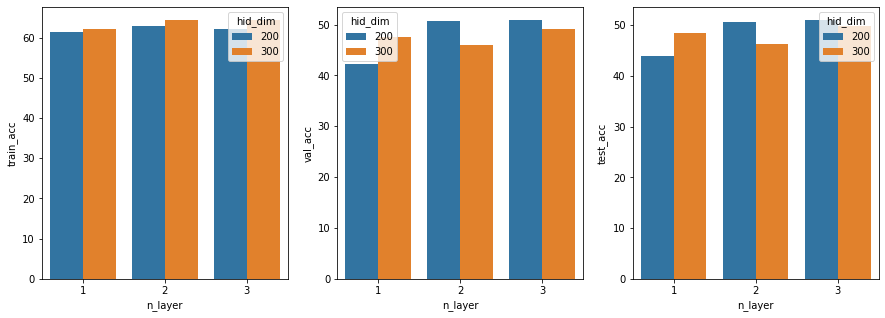

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt
results = load_exp_result('exp1')
# 가장 마지막 epoch에서의 train, val, test accuracy
f, ax = plt.subplots(1,3, figsize=(15,5))
sns.barplot(x='n_layer', y='train_acc', hue='hid_dim', data=results, ax=ax[0])
sns.barplot(x='n_layer', y='val_acc', hue='hid_dim', data=results, ax=ax[1])
sns.barplot(x='n_layer', y='test_acc', hue='hid_dim', data=results, ax=ax[2])
plt.show()

- epoch에 따른 loss 및 accuracy 변화를 실험한 두 파라미터 관점에서 plotting

In [90]:
results = load_exp_result('exp1')
var1 = 'n_layer'
var2 = 'hid_dim'

# 실험한 파라미터 값 리스트
li_var1 = results[var1].unique()
li_var2 = results[var2].unique()
loss_data = []
acc_data = []

for v1 in li_var1:
    for v2 in li_var2:
        row = results.loc[results[var1] == v1]   # 모수1 값이 v1인 행만 모음
        row = row.loc[results[var2] == v2] # 그 중 모수2가 v2인 행
        
        train_losses = row.train_losses.values[0]
        val_losses = row.val_losses.values[0]
        
        for epoch, train_loss in enumerate(train_losses):
            loss_data.append({'type': 'train', 'loss': train_loss, 'epoch': epoch, var1:v1, var2:v2})
        for epoch, val_loss in enumerate(val_losses):
            loss_data.append({'type': 'val', 'loss': val_loss, 'epoch': epoch, var1:v1, var2:v2})
        
        train_accs = row.train_accs.values[0]
        val_accs = row.val_accs.values[0]
        
        for epoch, train_acc in enumerate(train_accs):
            acc_data.append({'type': 'train', 'acc': train_acc, 'epoch': epoch, var1:v1, var2:v2})
        for epoch, val_acc in enumerate(val_accs):
            acc_data.append({'type': 'val', 'acc': val_acc, 'epoch': epoch, var1:v1, var2:v2})    

loss_df = pd.DataFrame(loss_data)
acc_df = pd.DataFrame(acc_data)

In [91]:
loss_df.head(30)

,type,loss,epoch,n_layer,hid_dim
0,train,1.786112,0,3,300
1,train,1.528065,1,3,300
2,train,1.420573,2,3,300
3,train,1.338771,3,3,300
4,train,1.271146,4,3,300
5,train,1.208353,5,3,300
6,train,1.154967,6,3,300
7,train,1.098934,7,3,300
8,train,1.047781,8,3,300
9,train,0.996281,9,3,300


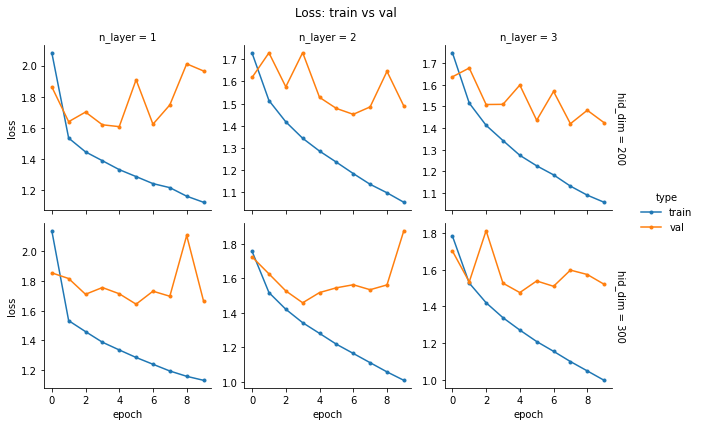

In [92]:
# row별, col별 type을 hue로 epoch vs loss를 plt.plot
g = sns.FacetGrid(loss_df, row=var2, col=var1, hue='type', margin_titles=True, sharey=False)
g = g.map(plt.plot, 'epoch', 'loss', marker='.')
g.add_legend()
g.fig.suptitle('Loss: train vs val', )
plt.subplots_adjust(top=0.89)

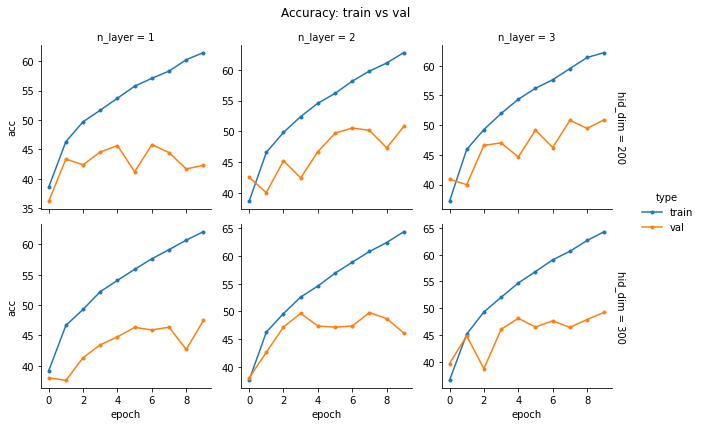

In [94]:
g = sns.FacetGrid(acc_df, row=var2, col=var1, hue='type', margin_titles=True, sharey=False)
g = g.map(plt.plot, 'epoch', 'acc', marker='.')
g.add_legend()
g.fig.suptitle('Accuracy: train vs val')
plt.subplots_adjust(top=0.89)